# Prophet and Timeseries

Predicting timeseries using facebook prophet.

### Introduction

Prophet (from facebook) is a tool for fitting a timeseries model.

In principle it is actually quite simple.

It tries to fit timeseries model using three components.

- A principle non periodic change. E.g. if you are predicting sales of a product this would represent the general growth of your business.
- Periodic change. A component that changes over a certain period in a regular fashion.
- Holidays. These are one off events that effect your business, think Christmas or Dawali. They may be on different days of the year each year.

More formaly we can write this as:

$$y(t) = g(t) + s(t) + h(t) + e_{t}$$

for the terms think, general, seasonal, holidays, and the final term is a general term.

We now essentially fit our data to the model much like a normal regression (but possibly with non-linear terms).

#### The general term

This is the growth (or negative growth) of your timeseries. This could be linear, or it could be logistic. It can also be piece wise. In general the model allows you to change regiemes. e.g. you might have exponential growth for two year, and then a plateau. There are many possibilities.

#### Seaonal Term

Modeled through a sine wave. In theory it could have different periodicity, but in practice it is limited (I think) to daily, weekly and yearly.

Note that it can handle quite arbitrary patterns of seasonality. It does this through a forrier analysis, so the data itself does not have to be a sine wave. You specify the number of terms in the analysis (default 10), if you add a lot it will find lots of high frequency terms, which may leed to overfitting (but too few might miss something genuine).

#### Holidays

These are kind of one off shocks to the system. There are some sensible defaults, but you could specify them yourself, as they are of course market specific. Are we in India, or a Christian country.

## Some Fake data

Let's give prophet a relatively easy task to solve. I'm going to give it some seaonal data that is also growing linearly.

This should really be easy to fit, as I'm using a simple model. Let's start here.

In [1]:
import pandas as pd
import random

In [2]:
def data_point(day):
    
    day_of_week = day.day_of_week
    if day_of_week == 0:
        correction = -1
    elif day_of_week == 1:
        correction = -0.2
    elif day_of_week == 6:
        correction = -0.4
    else:
        correction = 0.2
        
    days_since_beginning = (day - pd.to_datetime('2020-01-01')).days
    
    return (0.7 + days_since_beginning*0.002
            + correction
            + random.normalvariate(0, 0.5)
           )
    
    
    

In [3]:
date_range = pd.date_range('2020-01-01', '2022-12-31')
y = map(data_point, date_range)

Now we have a date and a value to predict. Let's put this into a data frame and plot it.

Note that prophet needs exaclty these names to work.

In [4]:
df = pd.DataFrame({'ds' : date_range,
              'y': y}
            )

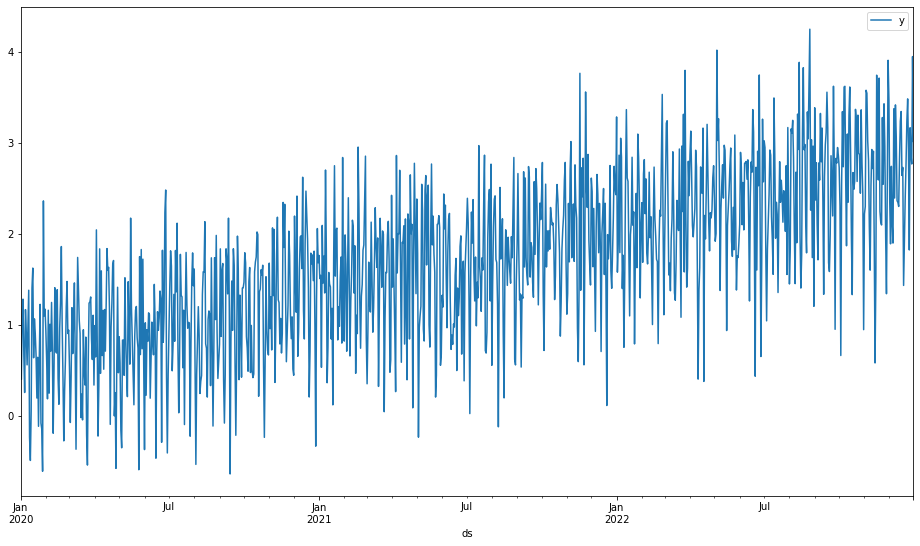

In [5]:
df.set_index('ds').plot(figsize=(16, 9))

That looks quite clear, although maybe the seasonality is not so clear. It is there though.

### Fitting the Model

From our data we can now fit the prophet model.

There are many options to give.

[This blog](https://www.analyticsvidhya.com/blog/2018/05/generate-accurate-forecasts-facebook-prophet-python-r/#:~:text=Prophet%20is%20an%20open%20source,of%20custom%20seasonality%20and%20holidays!) is a nice introduction.

In summary:

trend parameters:

- growth, either linear or logistic.
- Changepoints, decrete points at which the timeseries can change. You can specify this if you have some prior knowledge of what is going on. Otherwise these can be found by the model.
- n_changepoints, if the above is not given, then you can specify the number of change points as an integer.
- changepoint_prior_scale: don't know what this one does.

Seasonality:

yearly/weekly/daily_seasonality: specify true or false to fit these components.

holidays: dataframe of holidays, date and name.

And there are others, investigate if you need them.

In [6]:
from prophet import Prophet

In [7]:
model = Prophet(growth='linear',
        n_changepoints=0,
        yearly_seasonality=False,
        daily_seasonality=False,
        weekly_seasonality=True
       )

What can we do with this?

The most obvious thing to do is to train the model.

In [8]:
model.fit(df)

Now we can do a number of things. The first obvious thing to do is to plot what it has given us.

We can make a prediction from what we have. Our "prediction" could be the date range that we already have.

In [9]:
forcast = model.predict(df)
forcast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-01,0.621417,0.254870,1.554394,0.621417,0.621417,0.293113,0.293113,0.293113,0.293113,0.293113,0.293113,0.0,0.0,0.0,0.914531
1,2020-01-02,0.623373,0.330473,1.570564,0.623373,0.623373,0.330332,0.330332,0.330332,0.330332,0.330332,0.330332,0.0,0.0,0.0,0.953705
2,2020-01-03,0.625329,0.298753,1.597092,0.625329,0.625329,0.325328,0.325328,0.325328,0.325328,0.325328,0.325328,0.0,0.0,0.0,0.950657
3,2020-01-04,0.627285,0.356914,1.617966,0.627285,0.627285,0.353451,0.353451,0.353451,0.353451,0.353451,0.353451,0.0,0.0,0.0,0.980736
4,2020-01-05,0.629241,-0.305182,0.967406,0.629241,0.629241,-0.295350,-0.295350,-0.295350,-0.295350,-0.295350,-0.295350,0.0,0.0,0.0,0.333891


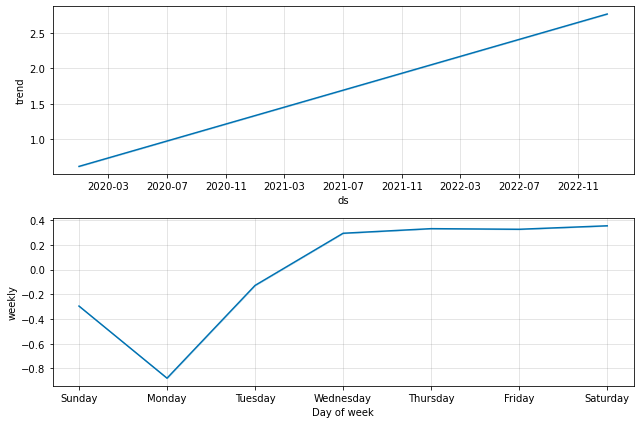

In [10]:
model.plot_components(forcast);

Given the simple model we supplied the forcast components are actually pretty close.

Let's plot the data and the outcome of the prediction together.

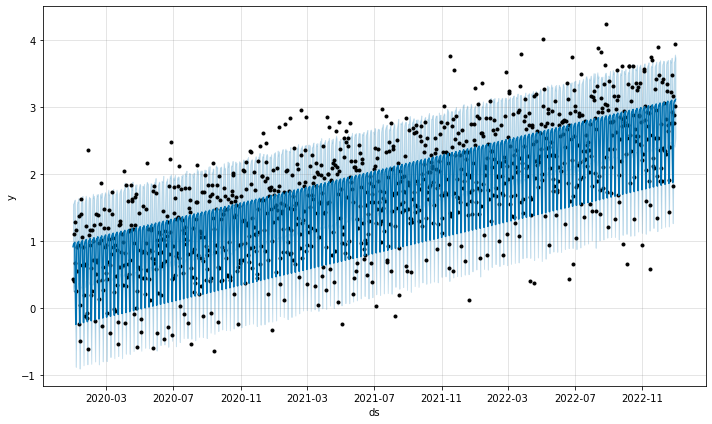

In [11]:
model.plot(forcast);

It looks kind of decent as far as eyeballing goes.

### Train and Test

Of course we were a bit naughty and fit the model on our all of our data. What would happen if we simulated a more realistic scenario, in which we fit upto a certain point, and then test the predictions against the next bit of data.

Let's fit on all but the last bit of the model, then we can predict the final 3 months.

In [12]:
train = (df
         .set_index('ds')
         .loc[:'2022-10-01']
         .reset_index()
        )

test = (df
         .set_index('ds')
         .loc['2022-10-01':]
         .reset_index()
        )

Train the same model that we had before, using only the training set this time.

In [13]:
model = Prophet(growth='linear',
        n_changepoints=0,
        yearly_seasonality=False,
        daily_seasonality=False,
        weekly_seasonality=True
       )

In [14]:
model.fit(train)

Now predict the test data

In [15]:
forcast = model.predict(test)
forcast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-10-01,2.592928,2.323725,3.577591,2.592928,2.592928,0.353204,0.353204,0.353204,0.353204,0.353204,0.353204,0.0,0.0,0.0,2.946132
1,2022-10-02,2.594896,1.702864,2.901902,2.594896,2.594896,-0.301849,-0.301849,-0.301849,-0.301849,-0.301849,-0.301849,0.0,0.0,0.0,2.293046
2,2022-10-03,2.596864,1.088263,2.339235,2.596864,2.596864,-0.870424,-0.870424,-0.870424,-0.870424,-0.870424,-0.870424,0.0,0.0,0.0,1.726440
3,2022-10-04,2.598831,1.837004,3.135086,2.598831,2.598831,-0.111952,-0.111952,-0.111952,-0.111952,-0.111952,-0.111952,0.0,0.0,0.0,2.486880
4,2022-10-05,2.600799,2.229225,3.517689,2.600799,2.600799,0.293559,0.293559,0.293559,0.293559,0.293559,0.293559,0.0,0.0,0.0,2.894358


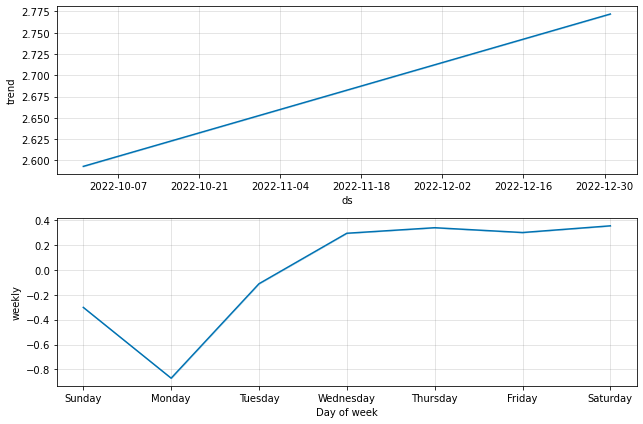

In [16]:
model.plot_components(forcast);

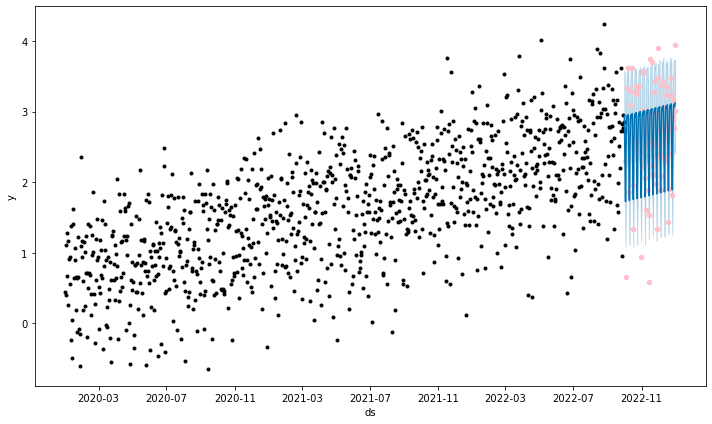

In [17]:
f = model.plot(forcast);
test.plot.scatter(ax=f.get_axes()[0],
                  x='ds',
                  y='y',
                  color='pink'
                 )

How to validate how good this is?

Essentially we can use the root mean squared error, or something similar.

The module has this built in and is easy to use.

In [18]:
from prophet.diagnostics import performance_metrics

In order to use it we need the dataframe of all the predictions together with the actual data.

In [19]:
joined = forcast.join(test, lsuffix='_forcast')
joined['cutoff'] = pd.to_datetime('2022-10-01')

In [20]:
df_p = performance_metrics(joined)

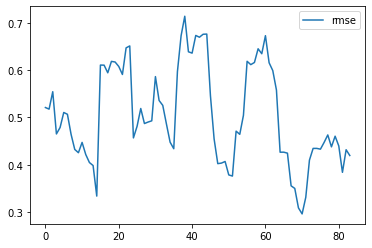

In [21]:
df_p.plot(y='rmse')

In [22]:
df_p.tail()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
79,87 days,0.212039,0.460477,0.415985,0.177850,0.160288,0.166037,0.777778
80,88 days,0.193520,0.439909,0.386359,0.150171,0.117461,0.142809,0.777778
81,89 days,0.147641,0.384240,0.343331,0.121564,0.117461,0.120162,0.888889
82,90 days,0.186541,0.431903,0.368835,0.116246,0.117461,0.121505,0.888889
83,91 days,0.176159,0.419713,0.345002,0.107270,0.106407,0.113179,0.888889


And what if we simply ask for the r^2 from the data, bypassing FBprophet.

In [23]:
joined.head()

,ds_forcast,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,ds,y,cutoff
0,2022-10-01,2.592928,2.323725,3.577591,2.592928,2.592928,0.353204,0.353204,0.353204,0.353204,0.353204,0.353204,0.0,0.0,0.0,2.946132,2022-10-01,2.727738,2022-10-01
1,2022-10-02,2.594896,1.702864,2.901902,2.594896,2.594896,-0.301849,-0.301849,-0.301849,-0.301849,-0.301849,-0.301849,0.0,0.0,0.0,2.293046,2022-10-02,2.302994,2022-10-01
2,2022-10-03,2.596864,1.088263,2.339235,2.596864,2.596864,-0.870424,-0.870424,-0.870424,-0.870424,-0.870424,-0.870424,0.0,0.0,0.0,1.726440,2022-10-03,0.662088,2022-10-01
3,2022-10-04,2.598831,1.837004,3.135086,2.598831,2.598831,-0.111952,-0.111952,-0.111952,-0.111952,-0.111952,-0.111952,0.0,0.0,0.0,2.486880,2022-10-04,2.545650,2022-10-01
4,2022-10-05,2.600799,2.229225,3.517689,2.600799,2.600799,0.293559,0.293559,0.293559,0.293559,0.293559,0.293559,0.0,0.0,0.0,2.894358,2022-10-05,3.342168,2022-10-01


In [24]:
y = joined.y
yhat = joined.yhat

In [25]:
import numpy as np

In [26]:
np.sqrt(np.mean(np.square(y - yhat)))

0.5134708593560255

That is relatively good, but there is of course a fair bit of noise in the generated signal.

In [27]:
from sklearn.metrics import r2_score

In [28]:
r2_score(y, yhat)

0.4561098341697548

### Excercises

1. Go back to the original random model. Make the noise term very very small. What do you expect to happen, what does happen?
2. With the same data as before try changing the number of fourier terms in your weekly data. What happens then?
3. Add to the random data generator some yearly seasonality, can your model still handle it?
4. Add to the randomness a step change, so that the gradient of linear increase changes at two points in the data. Try predicting this, allowing default detection of the points at which the data changes. Now try telling the model where these changes occur.
5. Add some holidays, these are random changes. Does the model find these itself, or does it need to be told where they are?
6. Try some other form of increase that is more complex, such as a exponential increase, or an initially explonetial, but then plateauing decrease, what happens here?
7. Feed your model with some real data? What about corona cases?

Bonus Question: The documentation mentions that the seasonality can also be multiplicative. Adjust the data generator to reflect this possibility and change the setting to see if you can still predict the data well.

To answer all of these questions I'm going to put everthing into one class to easily play with it.

In [29]:
def linear_weekly(day, noise):

    day_of_week = day.day_of_week
    if day_of_week == 0:
        correction = -1
    elif day_of_week == 1:
        correction = -0.2
    elif day_of_week == 6:
        correction = -0.4
    else:
        correction = 0.2

    days_since_beginning = (day -
                            pd.to_datetime('2020-01-01')).days

    return (0.7 + days_since_beginning*0.002
            + correction
            + random.normalvariate(0, noise)
           )
    

In [217]:
class TimeSeriesModel:
    
    def __init__(self, noise=0.05,
                 start='2020-01-01', stop='2022-12-31',
                data_fn=linear_weekly):
        
        self.noise = noise
        self.start = start
        self.stop = stop
        
        self.data_point = data_fn
        
        self.setup()
        
    def setup(self):
        
        self.df = self.make_fake_data()
        self.train, self.test = self.train_test()


    def make_fake_data(self):
        
        date_range = pd.date_range(self.start, self.stop)
        y = [self.data_point(d, self.noise) for d in date_range]

        return  pd.DataFrame({'ds' : date_range,
                              'y': y}
                            )
    
    def train_test(self, cutoff='2022-10-01'):
        
        train = (self.df
                     .set_index('ds')
                     .loc[:cutoff]
                     .reset_index()
                    )

        test = (self.df
                 .set_index('ds')
                 .loc[cutoff:]
                 .reset_index()
                )
        
        return train, test

    def make_model(self, **kwargs):

        self.model = Prophet(**kwargs)
        
    def fit(self):
        
        self.model.fit(self.train)
        
    def forcast(self):

        self._forcast = self.model.predict(self.df)

    def plot(self):

        f = self.model.plot(self._forcast)
        
    def plot_components(self):
        return self.model.plot_components(self._forcast)
    
    def plot_data(self):
        return self.df.set_index('ds').plot()
        
    def r2(self, whole_data=False):
        
        if whole_data:
            y = self.df.y
            yhat = (self
                    ._forcast
                    .yhat
                   )
        else:
            y = self.test.y
            yhat = (self
                    ._forcast
                    .set_index('ds')
                    .loc['2022-10-01':]
                    .yhat
                   )
        
        return r2_score(y, yhat)


### 1

r^2 = 0.4477


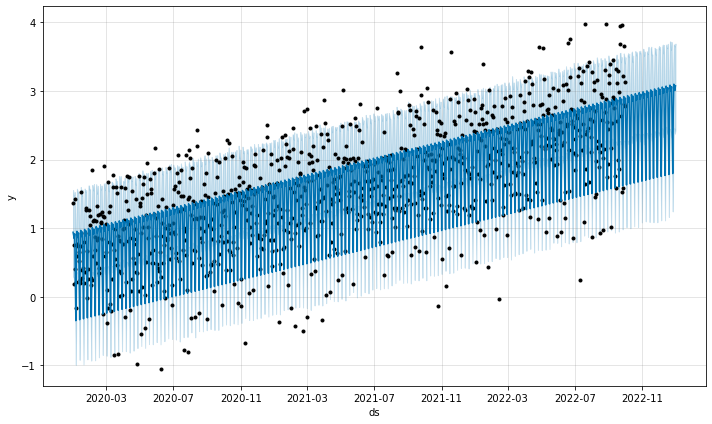

In [91]:
m = TimeSeriesModel(0.5)
m.make_model(growth='linear',
             n_changepoints=0,
             yearly_seasonality=False,
             daily_seasonality=False,
             weekly_seasonality=True)

m.fit()
m.forcast()

m.plot()

print('r^2 = {:.4f}'.format(m.r2()))

r^2 = 1.0000


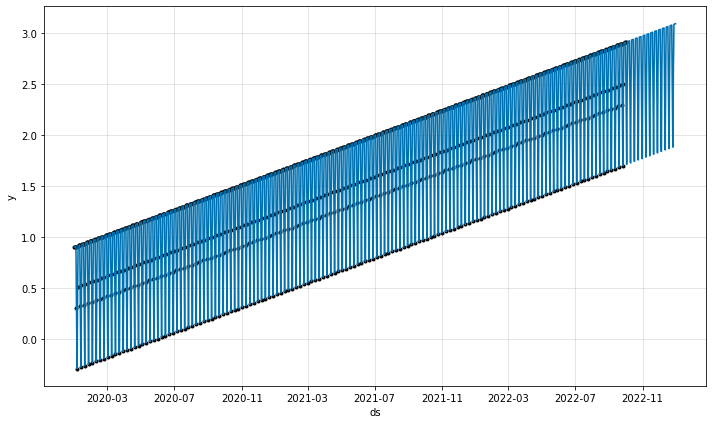

In [89]:
m = TimeSeriesModel(0.000005)
m.make_model(growth='linear',
             n_changepoints=0,
             yearly_seasonality=False,
             daily_seasonality=False,
             weekly_seasonality=True)

m.fit()
m.forcast()

m.plot()

print('r^2 = {:.4f}'.format(m.r2()))

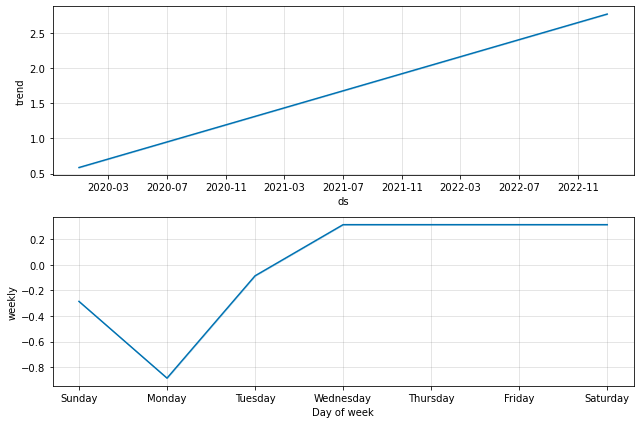

In [90]:
m.plot_components();

### 2

The second question asks about what happens if we include fewer (or more) fourier transform components in the weekly seasonality.

r^2 = 0.8946


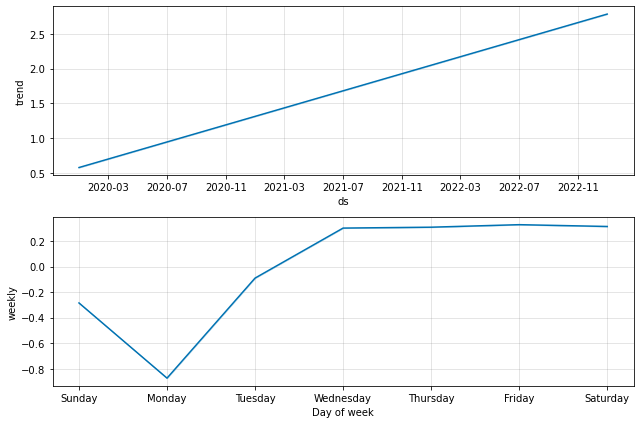

In [92]:
m = TimeSeriesModel(0.15)
m.make_model(growth='linear',
             n_changepoints=0,
             yearly_seasonality=False,
             daily_seasonality=False,
             weekly_seasonality=True)

m.fit()
m.forcast()

print('r^2 = {:.4f}'.format(m.r2()))

m.plot_components();

r^2 = 0.6477


r^2 = 0.8951
r^2 = 0.9160


r^2 = 0.8676


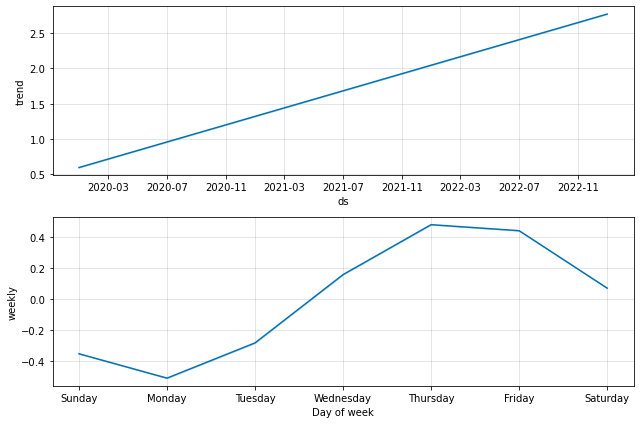

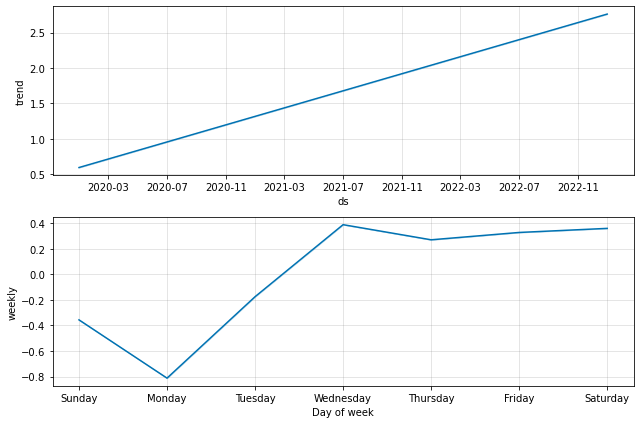

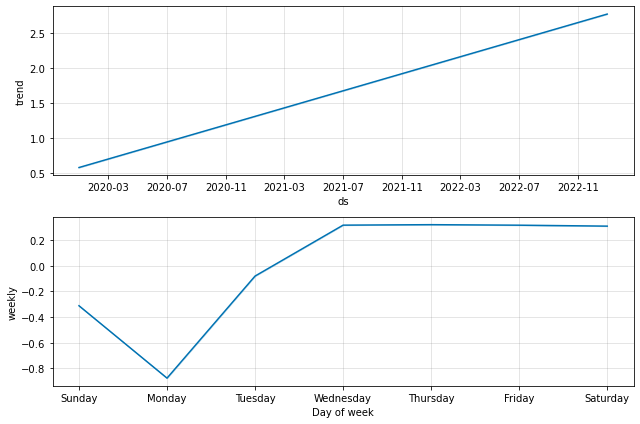

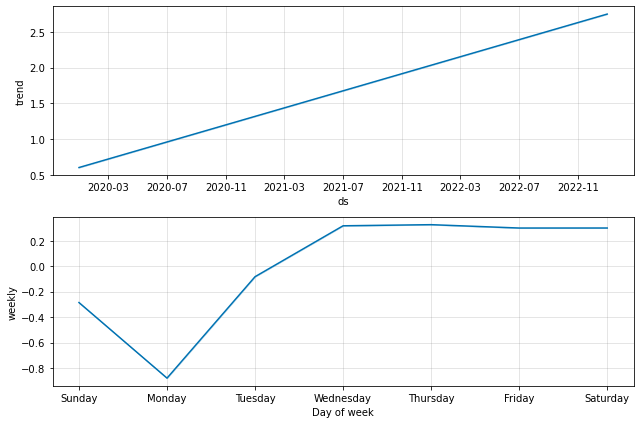

In [93]:
for i in range(1, 5):
    m = TimeSeriesModel(0.15)
    m.make_model(growth='linear',
                 n_changepoints=0,
                 yearly_seasonality=False,
                 daily_seasonality=False,
                 weekly_seasonality=i)

    m.fit()
    m.forcast()

    print('r^2 = {:.4f}'.format(m.r2()))

    m.plot_components();

With only one component it is forced into making and actual sine wave, which captures something, but is less accurate. With 2 or at least 3 it gets most of the way there, so this is enough for this example.

### 3

Add to the random data generator some yearly seasonality, can your model still handle it?

In [94]:
import math

In [95]:
def linear_yearly(day, noise):
    
    base = linear_weekly(day, noise)
    
    doy = day.day_of_year
    adj = math.sin(doy/365*2*math.pi)
    
    return base + 0.8*adj
    

First turning off the yearly seasonality, I guess the prediction should be somewhat worse.

r^2 = 0.1648


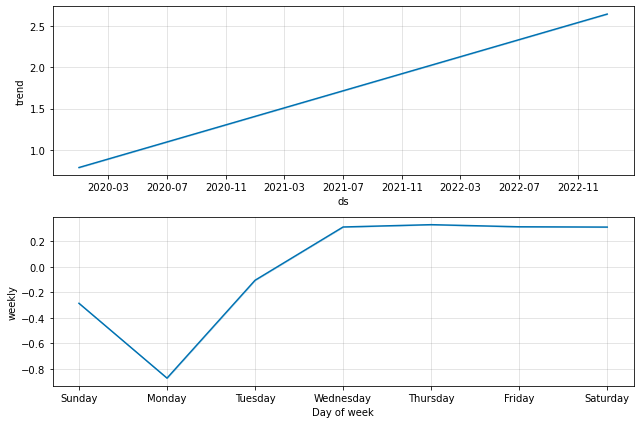

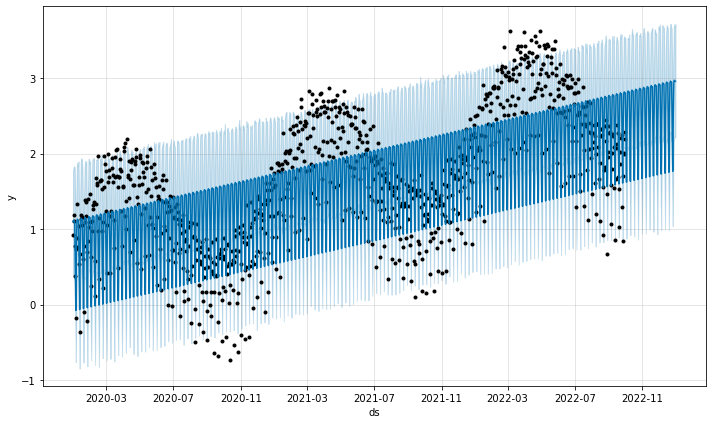

In [96]:
m = TimeSeriesModel(0.15, data_fn=linear_yearly)
m.make_model(growth='linear',
             n_changepoints=0,
             yearly_seasonality=False,
             daily_seasonality=False,
             weekly_seasonality=True)

m.fit()
m.forcast()

print('r^2 = {:.4f}'.format(m.r2()))

m.plot_components();

m.plot()

Now turn it back on again.

r^2 = 0.9083


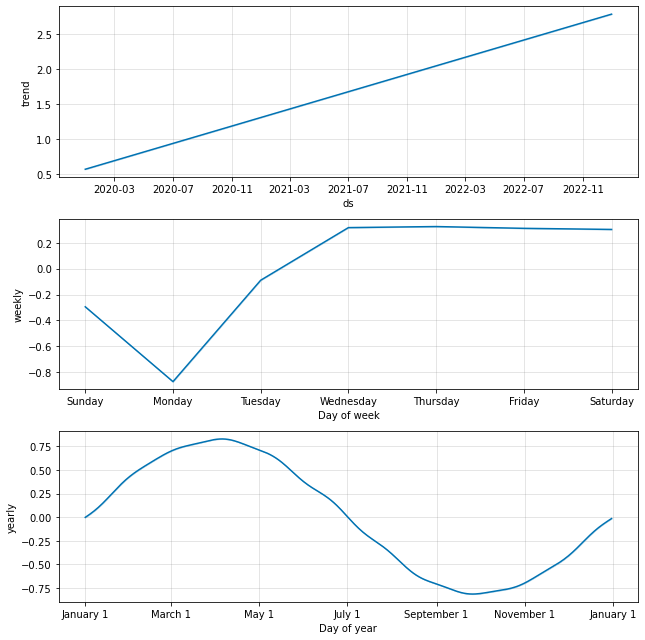

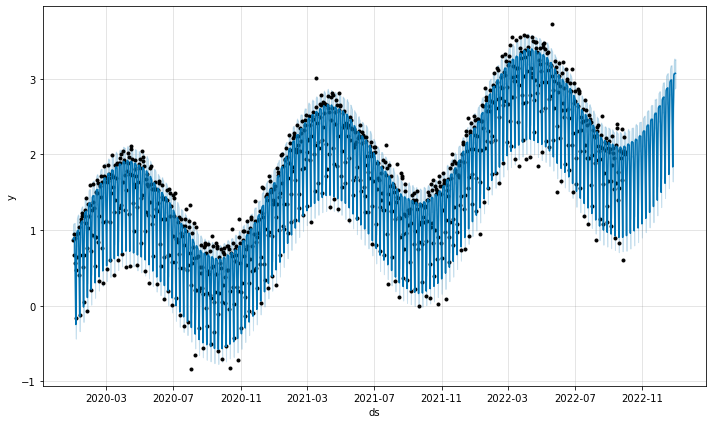

In [97]:
m = TimeSeriesModel(0.15, data_fn=linear_yearly)
m.make_model(growth='linear',
             n_changepoints=0,
             yearly_seasonality=True,
             daily_seasonality=False,
             weekly_seasonality=True)

m.fit()
m.forcast()

print('r^2 = {:.4f}'.format(m.r2()))

m.plot_components();

m.plot()

#### 4

4. Add to the randomness a step change, so that the gradient of linear increase changes at two points in the data. Try predicting this, allowing default detection of the points at which the data changes. Now try telling the model where these changes occur.

In [98]:
def linear_step(day, noise):
    
    day_of_week = day.day_of_week
    if day_of_week == 0:
        correction = -1
    elif day_of_week == 1:
        correction = -0.2
    elif day_of_week == 6:
        correction = -0.4
    else:
        correction = 0.2

    days_since_beginning = (day -
                            pd.to_datetime('2020-01-01')).days
    
    # Gradients of the three lines
    m1, m2, m3 = 0.002, 0.012, 0.0001 
    # The points (in days) at which the gradient changes
    a, b = 100, 400
    
    # intercepts, the first is a free parameter, the others
    # are bound by the condition of being continous.
    c1 = 0.7
    c2 = c1 + a*(m1 - m2)
    c3 = c2 + b*(m2 - m3)

    if days_since_beginning <= a:
        grad = m1
        intercept = c1
    elif days_since_beginning <= b:
        grad = m2
        intercept = c2
    else:
        grad = m3
        intercept = c3

    return (intercept
            + days_since_beginning*grad
            + correction
            + random.normalvariate(0, noise)
           )

Let's first try this forcing the fit not to use any change points. I imagine it won't do so well, but could still get a bit of the variation.

r^2 = -5.9455


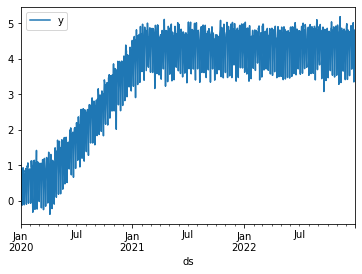

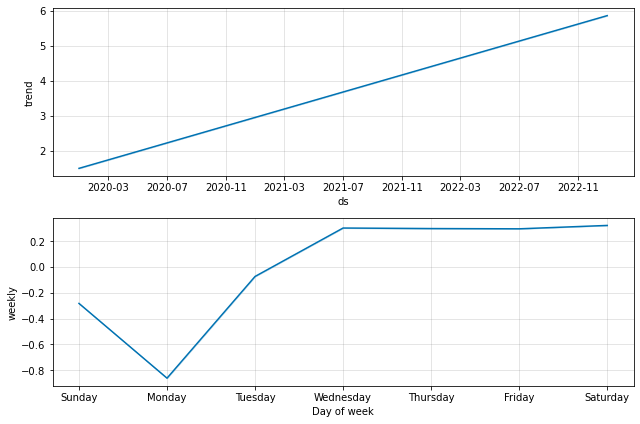

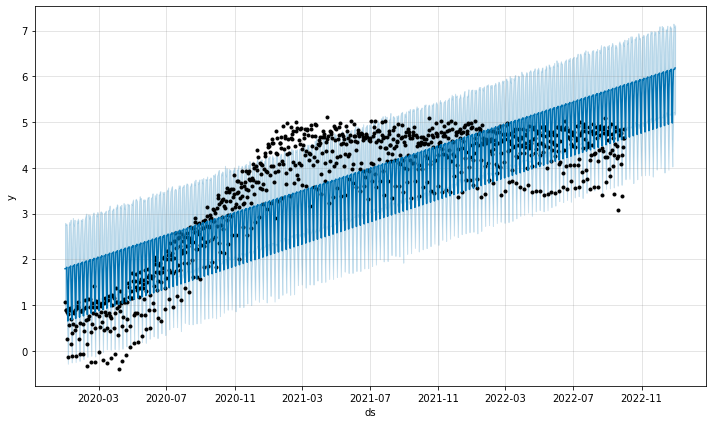

In [99]:
m = TimeSeriesModel(0.15, data_fn=linear_step)

m.make_model(growth='linear',
             n_changepoints=0,
             yearly_seasonality=False,
             daily_seasonality=False,
             weekly_seasonality=True)

m.plot_data()

m.fit()
m.forcast()

print('r^2 = {:.4f}'.format(m.r2()))

m.plot_components();

m.plot()

It indeed does quite poorly. The prediction is consitently above the data, but it has found some information there.

Now what happens if we don't constrain it at all, and just let it do its business.

r^2 = 0.8474
r^2 = 0.9886 (over all data including training)


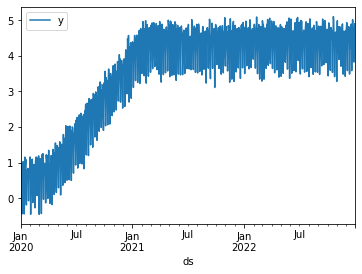

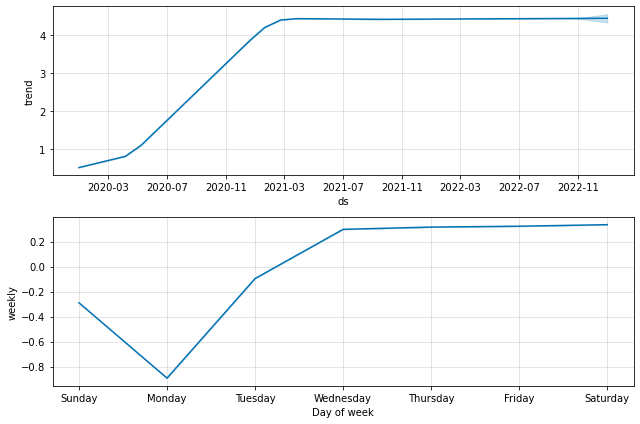

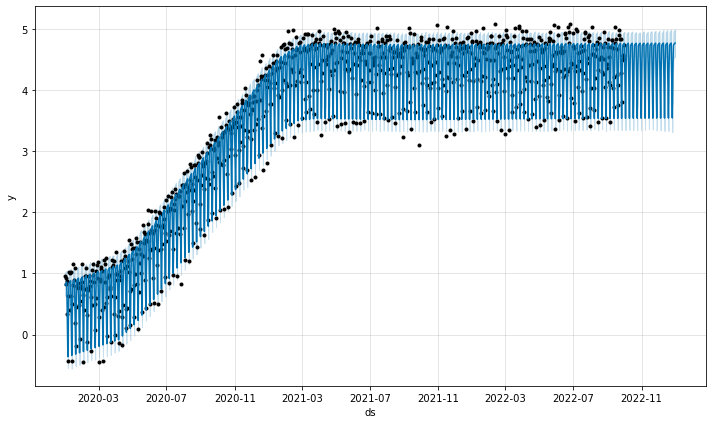

In [100]:
m = TimeSeriesModel(0.15, data_fn=linear_step)

m.make_model(growth='linear',
             yearly_seasonality=False,
             daily_seasonality=False,
             weekly_seasonality=True)

m.plot_data()

m.fit()
m.forcast()

print('r^2 = {:.4f}'.format(m.r2()))
print('r^2 = {:.4f} (over all data including training)'.format(m.r2(whole_data=True)))

m.plot_components();

m.plot()

In [101]:
m.model.n_changepoints

25

It seems like it has made a load of change points. What happens if we give it the actual answer.

r^2 = 0.8628
r^2 = 0.9800 (over all data including training)


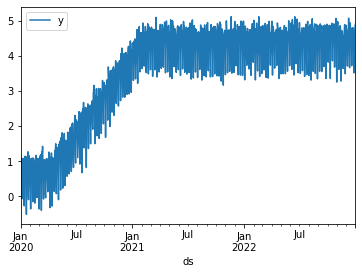

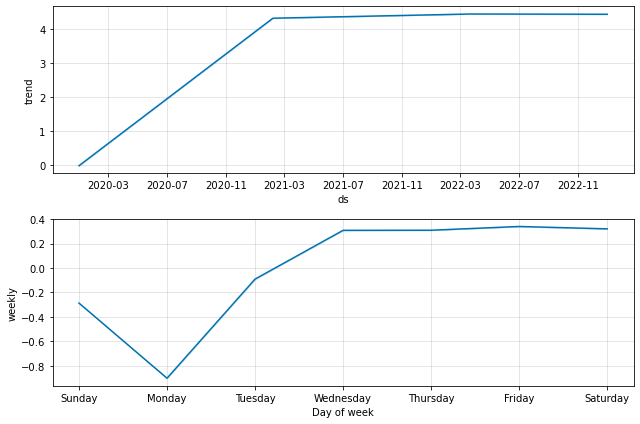

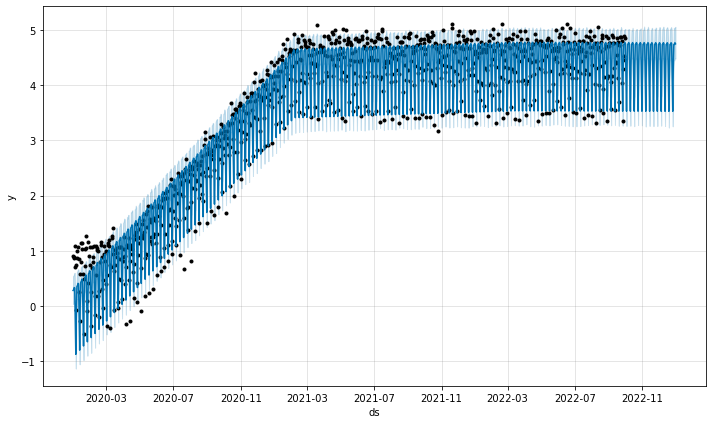

In [102]:
m = TimeSeriesModel(0.15, data_fn=linear_step)

m.make_model(growth='linear',
             yearly_seasonality=False,
             daily_seasonality=False,
             weekly_seasonality=True,
            n_changepoints=2)

m.plot_data()

m.fit()
m.forcast()

print('r^2 = {:.4f}'.format(m.r2()))
print('r^2 = {:.4f} (over all data including training)'.format(m.r2(whole_data=True)))

m.plot_components();

m.plot()

Giving it the right answer it actually does rather badly! Putting the change point in the wrong place weirdly!

In [103]:
from datetime import timedelta

In [104]:
ch1 = pd.to_datetime('2020-01-01') + timedelta(days=100)
ch2 = pd.to_datetime('2020-01-01') + timedelta(days=400)

r^2 = 0.9107
r^2 = 0.9890 (over all data including training)


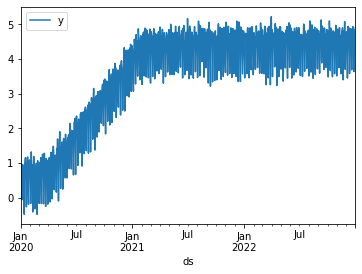

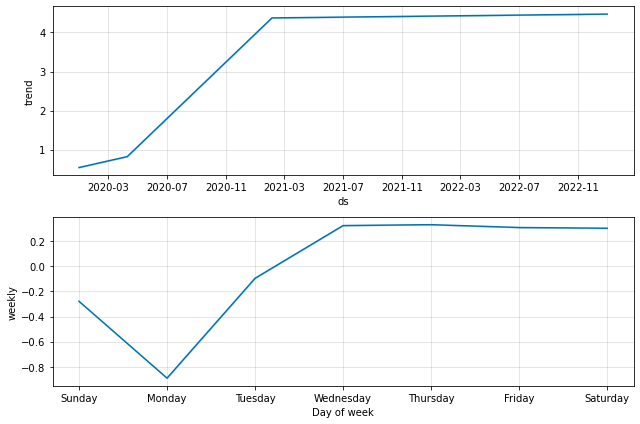

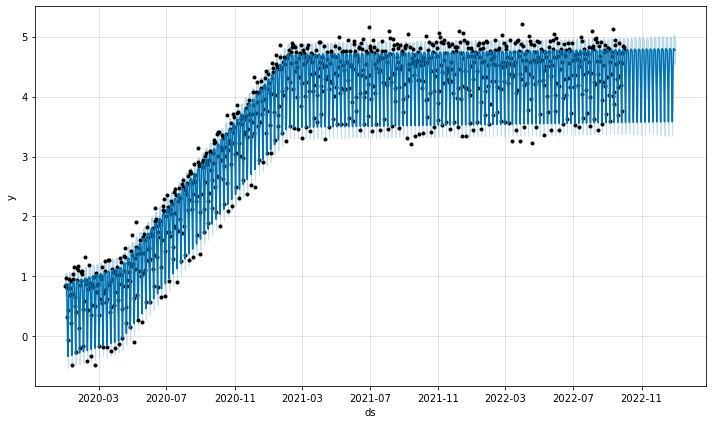

In [105]:
m = TimeSeriesModel(0.15, data_fn=linear_step)

m.make_model(growth='linear',
             changepoints=[ch1, ch2],
             yearly_seasonality=False,
             daily_seasonality=False,
             weekly_seasonality=True)

m.plot_data()

m.fit()
m.forcast()

print('r^2 = {:.4f}'.format(m.r2()))
print('r^2 = {:.4f} (over all data including training)'.format(m.r2(whole_data=True)))

m.plot_components();

m.plot()

Interesting. Specifying the exact change points does some good, but specifying how many actually harmed the model.

### 5

5. Add some holidays, these are random changes. Does the model find these itself, or does it need to be told where they are?

In [128]:
def yearly_holidays(day, noise):
    
    base = linear_yearly(day, noise)
    
    # Let's use a made up holiday, which is feb 25, with
    # some noise around it.

    if day.month == 2 and day.day == 25:
        addition = 3
    elif day.month == 2 and day.day == 24:
        addition = 1
    elif day.month == 2 and day.day == 23:
        addition = 0.5
    elif day.month == 2 and day.day == 23:
        addition = 1.2
    else:
        addition = 0
        
    return base + addition

r^2 = 0.9073
r^2 = 0.9658 (over all data including training)


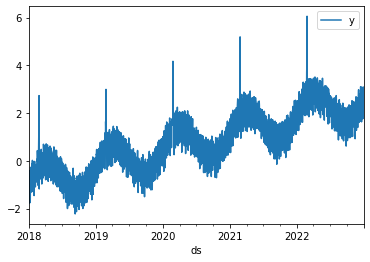

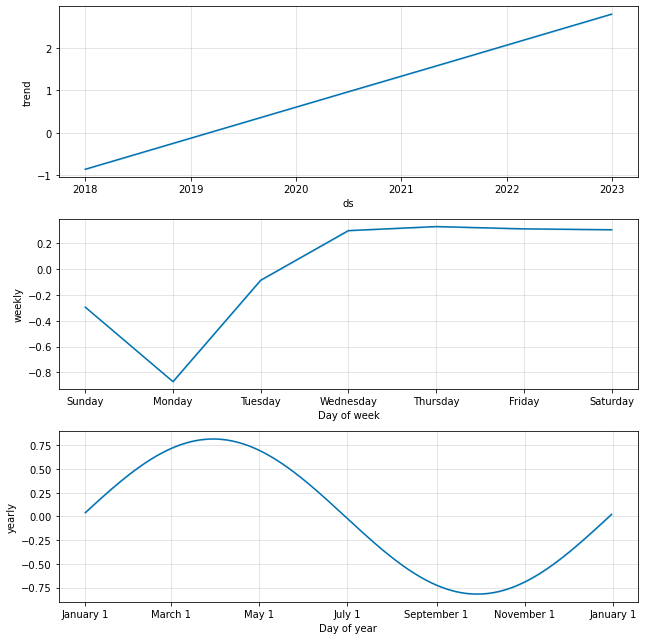

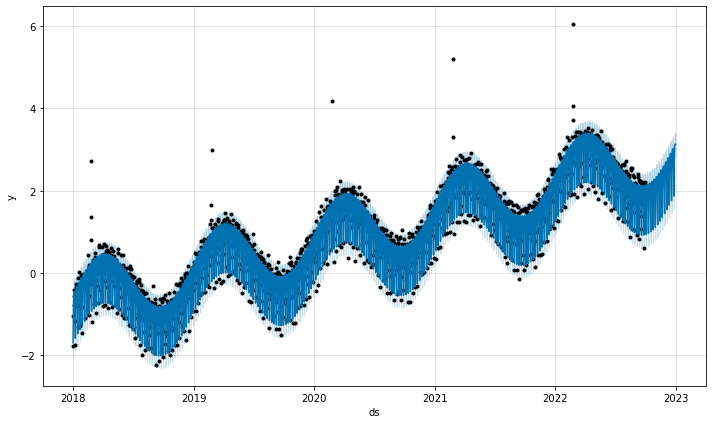

In [139]:
m = TimeSeriesModel(0.15, data_fn=yearly_holidays,
                    start='2018-01-01')

m.make_model(growth='linear',
             yearly_seasonality=1,
             daily_seasonality=False,
             weekly_seasonality=True)

m.plot_data()

m.fit()
m.forcast()

print('r^2 = {:.4f}'.format(m.r2()))
print('r^2 = {:.4f} (over all data including training)'.format(m.r2(whole_data=True)))

m.plot_components();

m.plot()

Note that the forriuer analysis term is able to capture a bit of the holiday affect, but it doesn't do it that well, and at the cost of adding some noise around the holiday that is not there in the data.

In [137]:
holidays = pd.DataFrame({
    'ds': ['2018-02-25', '2019-02-25',
           '2020-02-25', '2021-02-25',
           '2022-02-25'],
    'holiday': ['national_flatulence_day']*5,
    'lower_window': [-2]*5,
    'upper_window': [1]*5
})

r^2 = 0.9129
r^2 = 0.9844 (over all data including training)


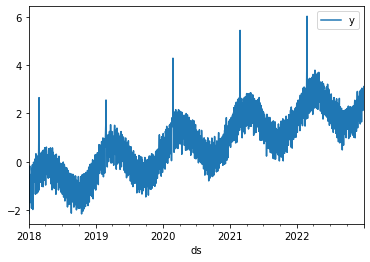

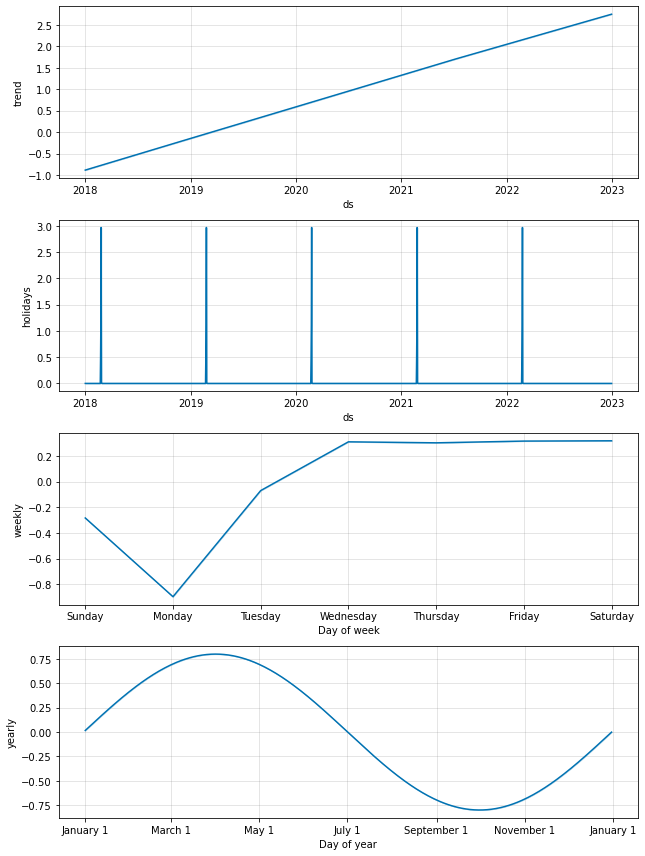

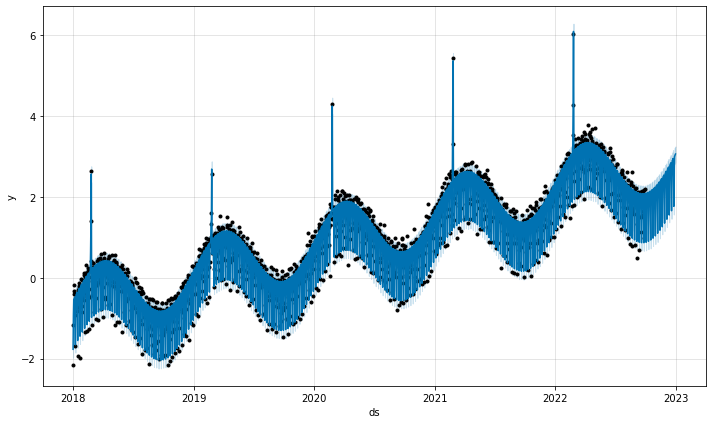

In [140]:
m = TimeSeriesModel(0.15, data_fn=yearly_holidays,
                    start='2018-01-01')

m.make_model(growth='linear',
             yearly_seasonality=1,
             daily_seasonality=False,
             weekly_seasonality=True,
             holidays=holidays
            )

m.plot_data()

m.fit()
m.forcast()

print('r^2 = {:.4f}'.format(m.r2()))
print('r^2 = {:.4f} (over all data including training)'.format(m.r2(whole_data=True)))

m.plot_components();

m.plot()

In this case it predicts it pretty well. Note that there is some mixing up of the seasonality with higher levels of fourier components and the holiday model. Forcing the fourier component to be one makes it cleaner, although this only works becuase my model is actually a sine wave.

There is clearly a lot to explore here, but it works in general.

### 6

6. Try some other form of increase that is more complex, such as a exponential increase, or an initially explonetial, but then plateauing decrease, what happens here?

Let's try a limited exponential increase. What will this do.

$$\frac{1}{1+e^{-x}}$$

In [142]:
import numpy as np

In [161]:
def sigmoid(day, noise):

    day_of_week = day.day_of_week
    if day_of_week == 0:
        correction = -1
    elif day_of_week == 1:
        correction = -0.2
    elif day_of_week == 6:
        correction = -0.4
    else:
        correction = 0.2

    days_since_beginning = (day -
                            pd.to_datetime('2020-01-01')).days
    
    sig = 1/(1 + np.exp(-days_since_beginning/100))

    return (0.7 + 
            + correction
            + sig
            + random.normalvariate(0, noise)
           )

r^2 = 0.4348
r^2 = 0.8272 (over all data including training)


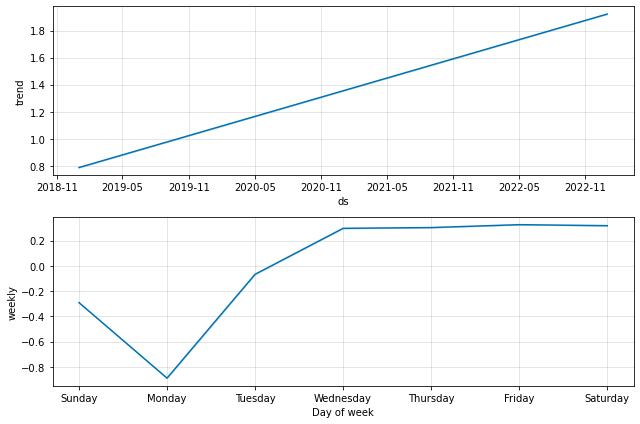

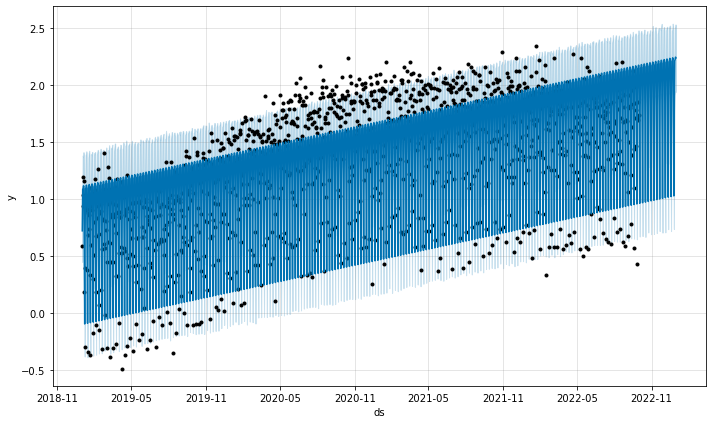

In [166]:
m = TimeSeriesModel(0.15, data_fn=sigmoid,
                    start='2019-01-01')

m.make_model(growth='linear',
             yearly_seasonality=False,
             daily_seasonality=False,
             weekly_seasonality=True,
             n_changepoints=0
            )

m.fit()
m.forcast()

print('r^2 = {:.4f}'.format(m.r2()))
print('r^2 = {:.4f} (over all data including training)'.format(m.r2(whole_data=True)))

m.plot_components();

m.plot()

In [ ]:
Prophet()

We also need to add a cap to our dataframe. Let's do this with some monkey pathcing.

In [170]:
TimeSeriesModel.setup??

In [174]:
def setup(self):
        
    self.df = self.make_fake_data()
    self.df['cap'] = 2.5
    self.train, self.test = self.train_test()
    
TimeSeriesModel.setup = setup

r^2 = 0.4941
r^2 = 0.8365 (over all data including training)


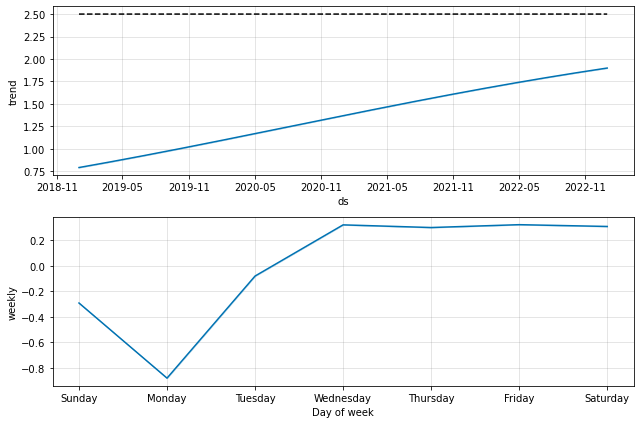

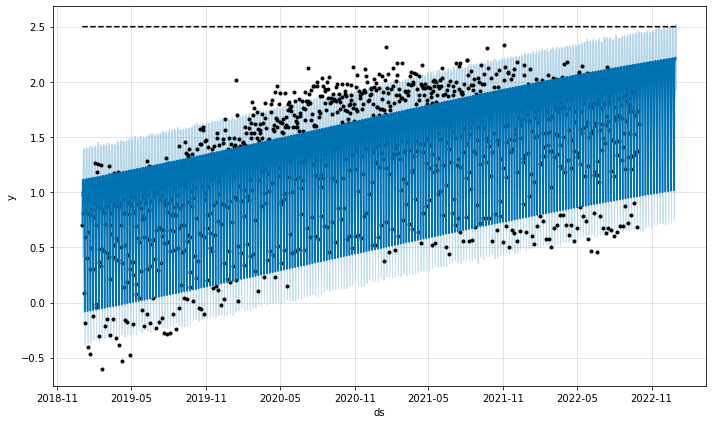

In [175]:
m = TimeSeriesModel(0.15, data_fn=sigmoid,
                    start='2019-01-01')

m.make_model(growth='logistic',
             yearly_seasonality=False,
             daily_seasonality=False,
             weekly_seasonality=True,
             n_changepoints=0
            )

m.fit()
m.forcast()

print('r^2 = {:.4f}'.format(m.r2()))
print('r^2 = {:.4f} (over all data including training)'.format(m.r2(whole_data=True)))

m.plot_components();

m.plot()

It doesn't actually do super well. The piece wise linear version does much better.

In general this is a very tricky problem of course.

### 7

7. Feed your model with some real data? What about corona cases?

In [197]:
corona_cases_all = pd.read_csv('../data/corona-cases.csv')

In [198]:
len(corona_cases_all)

92232

In [199]:
data = (corona_cases_all
        [corona_cases_all['covid19_csse_snapshot.cc1'] == 'gb']
        [['covid19_csse_snapshot.yyyy_mm_dd', 'covid19_csse_snapshot.confirmed']]
       )

data.columns = ['ds', 'y']

In [200]:
data.head()

,ds,y
179,2020-01-22,0
368,2020-01-23,0
557,2020-01-24,0
746,2020-01-25,0
935,2020-01-26,0


In [201]:
data.ds.iloc[0]

'2020-01-22'

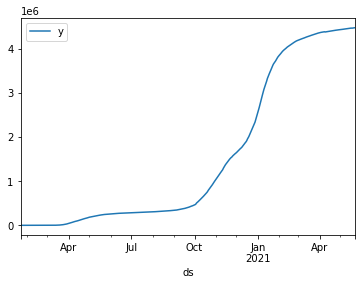

In [202]:
data['ds'] = pd.to_datetime(data['ds'])
data.set_index('ds').plot()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


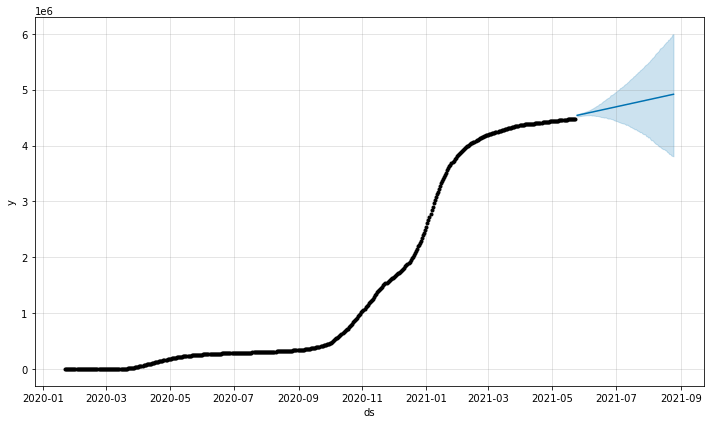

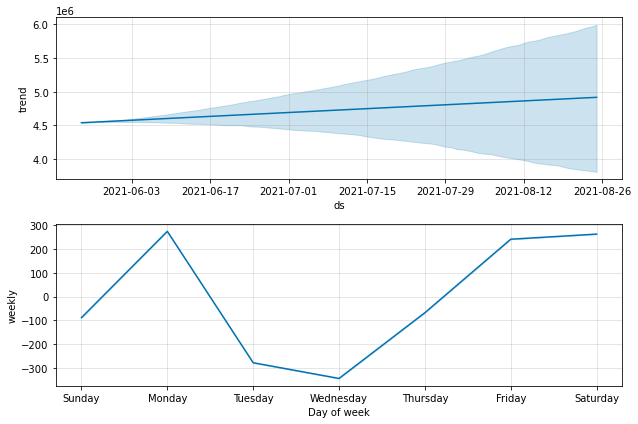

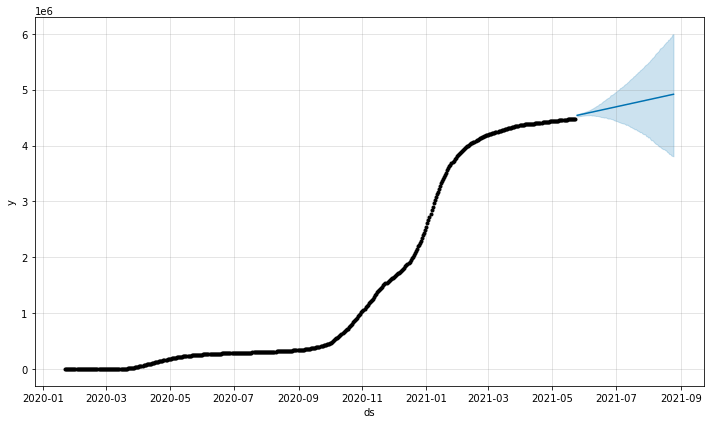

In [212]:
model = Prophet()
model.fit(data)
the_future = pd.DataFrame({'ds': pd.date_range('2021-05-25', '2021-08-25')})
both = data[['ds']].append(the_future)
forcast = model.predict(the_future)
model.plot_components(forcast)
model.plot(forcast)

Cool. Of course anything could happen!

### Bonus

Multiplicative seasonality.

This is easy enough to do.

In [227]:
def linear_weekly_mul(day, noise):

    day_of_week = day.day_of_week
    if day_of_week == 0:
        correction = 1.1
    elif day_of_week == 1:
        correction = 1.2
    elif day_of_week == 6:
        correction = .9
    else:
        correction = 1

    days_since_beginning = (day -
                            pd.to_datetime('2020-01-01')).days

    return (0.7 + days_since_beginning*0.002*correction
            + random.normalvariate(0, noise)
           )

r^2 = 0.3282
r^2 = 0.9663 (over all data including training)


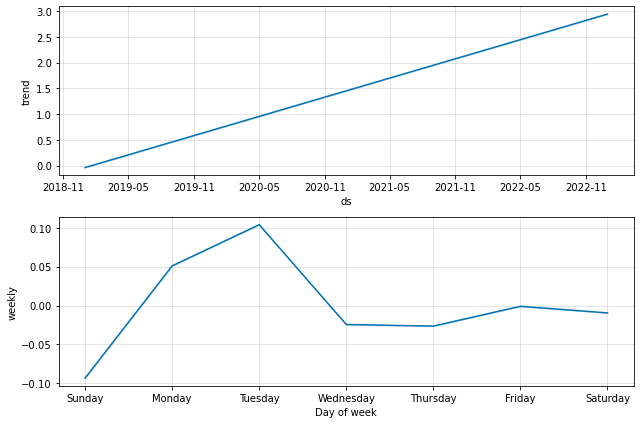

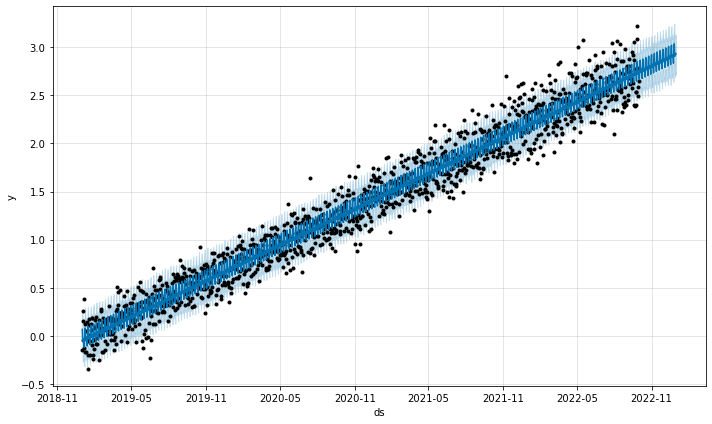

In [228]:
m = TimeSeriesModel(0.15, data_fn=linear_weekly_mul,
                    start='2019-01-01')

m.make_model(growth='linear',
             yearly_seasonality=False,
             daily_seasonality=False,
             weekly_seasonality=True,
             n_changepoints=0
            )

m.fit()
m.forcast()

print('r^2 = {:.4f}'.format(m.r2()))
print('r^2 = {:.4f} (over all data including training)'.format(m.r2(whole_data=True)))

m.plot_components()

m.plot()

And it does a terrible job at predicting this, maybe not surprisingly.

r^2 = 0.4396
r^2 = 0.8055 (over all data including training)


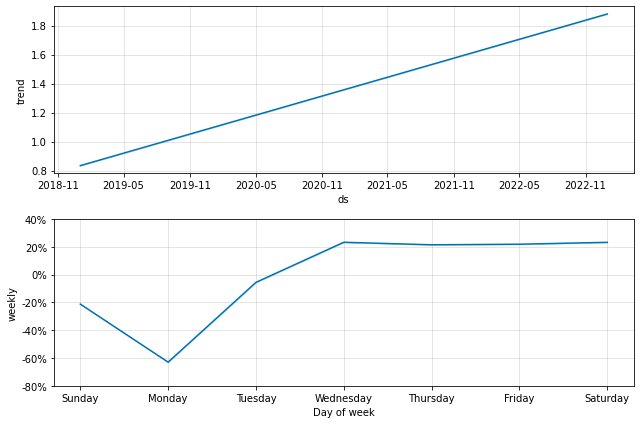

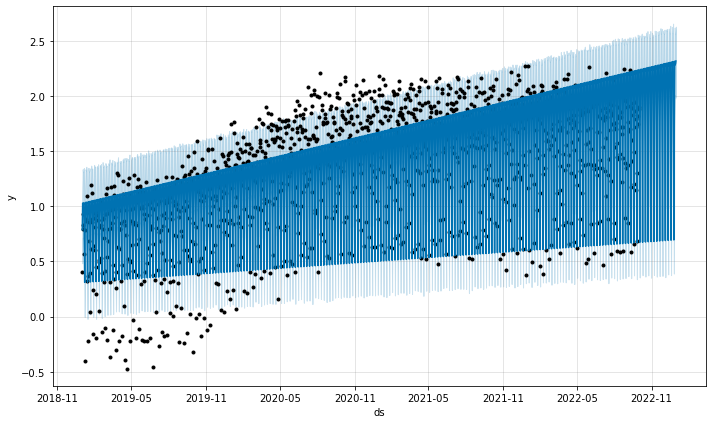

In [229]:
m = TimeSeriesModel(0.15, data_fn=sigmoid,
                    start='2019-01-01')

m.make_model(growth='linear',
             yearly_seasonality=False,
             daily_seasonality=False,
             weekly_seasonality=True,
             n_changepoints=0,
             seasonality_mode = 'multiplicative'
            )

m.fit()
m.forcast()

print('r^2 = {:.4f}'.format(m.r2()))
print('r^2 = {:.4f} (over all data including training)'.format(m.r2(whole_data=True)))

m.plot_components();

m.plot()

Not sure if that's what it really means, but it does something interesting.